<a href="https://colab.research.google.com/github/robetcoding/SMKCoding_Kanesa_Robet/blob/master/Training_ANN_Heater.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--- Membaca File: CoolTerm Capture (Untitled_0) 2025-12-05 22-36-49-581.txt ---
Jumlah Data Valid: 2113 sampel
Contoh Data 5 Baris Teratas:
    Suhu  Error  DeltaError   PWM
0  20.75  19.25        1.75  90.0
1  22.75  17.25       -2.00  90.0
2  22.50  17.50        0.25  90.0
3  21.25  18.75        1.25  90.0
4  22.00  18.00       -0.75  90.0


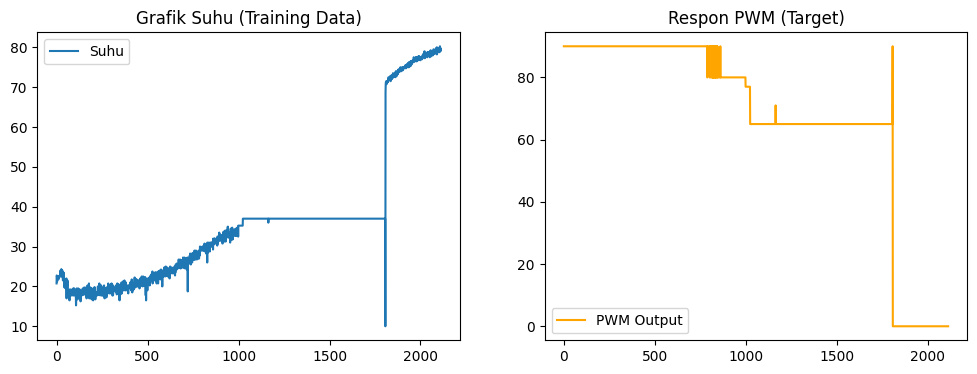

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Memulai Training ANN ---
Training Selesai. Final Loss (MSE): 1.1800
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


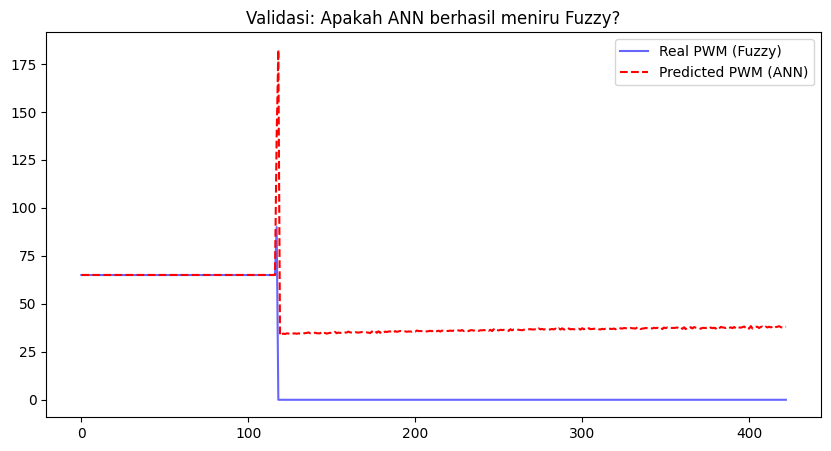


--- Mengonversi Model ke Hex Array untuk ESP32 ---
Saved artifact at '/tmp/tmps2l8j3l7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138304986375056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138304986376208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138304986374864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138304986373712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138304986376784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138304986373136: TensorSpec(shape=(), dtype=tf.resource, name=None)
SUKSES! File 'model_heater.h' telah dibuat.
Silakan download file tersebut dan copy isinya ke Arduino IDE.
Isi awal file Hex Anda:
const unsigned char model_data[] = {
0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re

# ==========================================
# 1. DATA PREPROCESSING (PEMBERSIHAN DATA)
# ==========================================
filename = "CoolTerm Capture (Untitled_0) 2025-12-05 22-36-49-581.txt"

print(f"--- Membaca File: {filename} ---")

# Membaca file baris per baris untuk memfilter teks non-data
clean_data = []
with open(filename, 'r') as f:
    for line in f:
        # Cari pola angka: "angka,angka,angka,angka"
        # Regex ini memastikan kita hanya mengambil baris yang valid (CSV)
        if re.match(r'^-?\d+(\.\d+)?,-?\d+(\.\d+)?,-?\d+(\.\d+)?,\d+$', line.strip()):
            clean_data.append(line.strip().split(','))

# Konversi ke Pandas DataFrame
columns = ['Suhu', 'Error', 'DeltaError', 'PWM']
df = pd.DataFrame(clean_data, columns=columns, dtype=float)

print(f"Jumlah Data Valid: {len(df)} sampel")
print("Contoh Data 5 Baris Teratas:")
print(df.head())

# Visualisasi Data Mentah
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(df['Suhu'], label='Suhu')
plt.title("Grafik Suhu (Training Data)")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(df['PWM'], color='orange', label='PWM Output')
plt.title("Respon PWM (Target)")
plt.legend()
plt.show()

# ==========================================
# 2. PERSIAPAN TRAINING
# ==========================================
# Fitur (Input): Error dan DeltaError
X = df[['Error', 'DeltaError']].values
# Label (Target): PWM
y = df['PWM'].values

# Split Data: 80% Training, 20% Validasi
split_idx = int(len(df) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# ==========================================
# 3. MEMBANGUN MODEL ARSITEKTUR (Deep Learning)
# ==========================================
model = tf.keras.Sequential([
    # Input Layer (2 Fitur) -> Hidden Layer 1 (16 Neuron, ReLU)
    # 16 Neuron cukup untuk menangkap non-linearitas heater tanpa memberatkan ESP32
    tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),

    # Hidden Layer 2 (16 Neuron, ReLU)
    tf.keras.layers.Dense(16, activation='relu'),

    # Output Layer (1 Neuron, Linear)
    # Kita tidak pakai Sigmoid karena PWM kita 0-90 (angka riil), bukan 0-1
    tf.keras.layers.Dense(1)
])

# Optimizer Adam dengan Learning Rate standar
# Loss Function MSE (Mean Squared Error) cocok untuk regresi angka PWM
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# ==========================================
# 4. PROSES TRAINING
# ==========================================
print("\n--- Memulai Training ANN ---")
history = model.fit(X_train, y_train,
                    epochs=200,         # 200 putaran belajar
                    batch_size=32,      # Belajar per 32 data
                    validation_data=(X_test, y_test),
                    verbose=0)          # Silent mode (biar tidak spam log)

# Cek hasil akhir
loss = history.history['loss'][-1]
print(f"Training Selesai. Final Loss (MSE): {loss:.4f}")

# Validasi Prediksi
predictions = model.predict(X_test)

# Plot Perbandingan (Kenyataan vs Prediksi AI)
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Real PWM (Fuzzy)', color='blue', alpha=0.6)
plt.plot(predictions, label='Predicted PWM (ANN)', color='red', linestyle='--')
plt.title("Validasi: Apakah ANN berhasil meniru Fuzzy?")
plt.legend()
plt.show()

# ==========================================
# 5. KONVERSI KE TENSORFLOW LITE (C++ Header)
# ==========================================
print("\n--- Mengonversi Model ke Hex Array untuk ESP32 ---")

# Convert ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT] # Optimasi Ukuran
tflite_model = converter.convert()

# Fungsi untuk membuat Hex Dump (C Style)
def hex_to_c_array(data, model_name="model_data"):
    c_str = ""
    c_str += f"const unsigned char {model_name}[] = {{\n"
    hex_array = []
    for i, val in enumerate(data):
        hex_array.append(f"0x{val:02x}")
    c_str += ", ".join(hex_array)
    c_str += "};\n"
    c_str += f"const int {model_name}_len = {len(data)};"
    return c_str

# Tulis ke file .h
header_content = hex_to_c_array(tflite_model)
with open("model_heater.h", "w") as f:
    f.write(header_content)

print("SUKSES! File 'model_heater.h' telah dibuat.")
print("Silakan download file tersebut dan copy isinya ke Arduino IDE.")
print("Isi awal file Hex Anda:")
print(header_content[:200] + "...")